# Benchmarking affine transforms using numpy, cupy and clesperanto.
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and [clEsperanto](https://github.com/clEsperanto/pyclesperanto_prototype/tree/master).

In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread, imshow
import numpy as np
import time
import cupy
from cupyx.scipy import ndimage as ndi
from scipy import ndimage as sndi
import stackview

In [2]:
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [3]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('TX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [4]:
image = imread('../03b_image_processing/data/Haase_MRT_tfl3d1.tif')

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 1, ..., 4, 4, 3],
                  ...,
                  [0, 0, 0, ..., 2, 3, 6],
                  [0, 0, 0, ..., 2, 6, 7],
                  [0, 0, 0, ..., 4, 6, 4]], dtype=uint8)
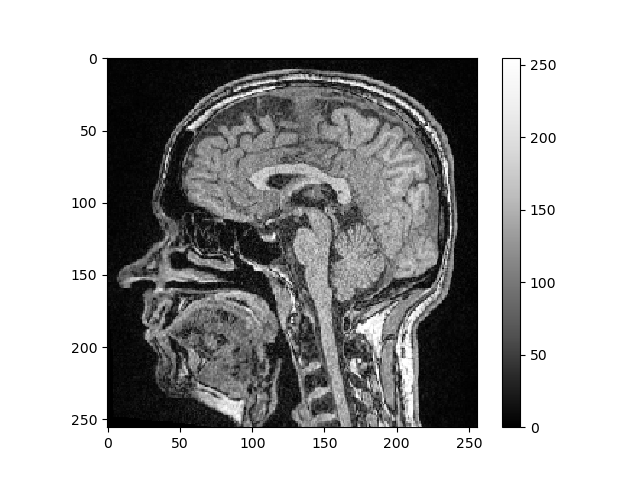
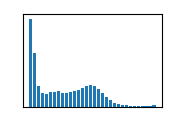

In [5]:
stackview.insight(image[96])

In [6]:
# scaling by factor
s = 0.5
matrix = np.asarray([
    [1/s, 0, 0, 0],
    [0, 1/s, 0, 0],
    [0, 0, 1/s, 0],
    [0, 0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) * s).astype(int))
print(output_shape)

(96, 128, 128)


## cupy

cupy affine transform duration: 0.13012480735778809
cupy affine transform duration: 0.03827500343322754
cupy affine transform duration: 0.03521728515625
cupy affine transform duration: 0.030150413513183594
cupy affine transform duration: 0.030646800994873047
cupy affine transform duration: 0.02948594093322754
cupy affine transform duration: 0.030394315719604492
cupy affine transform duration: 0.0323793888092041
cupy affine transform duration: 0.032364606857299805
cupy affine transform duration: 0.02682209014892578


StackViewNDArray([[-1.10378972e-09,  3.51832977e-09,  3.00092836e-08,
                   ..., -2.64909529e-08,  4.07022462e-08,
                   -1.77986088e-08],
                  [ 8.27842296e-09,  1.00000007e+00,  5.00000000e+00,
                   ...,  3.00000004e+00,  2.99999988e+00,
                    4.00000009e+00],
                  [-6.07084329e-09,  1.99999991e+00,  4.99999987e+00,
                   ...,  2.99999989e+00,  4.00000024e+00,
                    4.00000003e+00],
                  ...,
                  [ 8.35387727e-11, -1.05097166e-09, -1.23982318e-08,
                   ...,  9.99999945e-01,  5.00000026e+00,
                    2.00000020e+00],
                  [-1.15876362e-11, -4.83379591e-11, -2.97505818e-10,
                   ...,  3.00000004e+00,  2.00000006e+00,
                    3.99999980e+00],
                  [ 8.84230942e-14,  2.51163699e-12, -7.14121711e-12,
                   ...,  4.00000009e+00,  4.00000014e+00,
                    6.00000008e+00]])
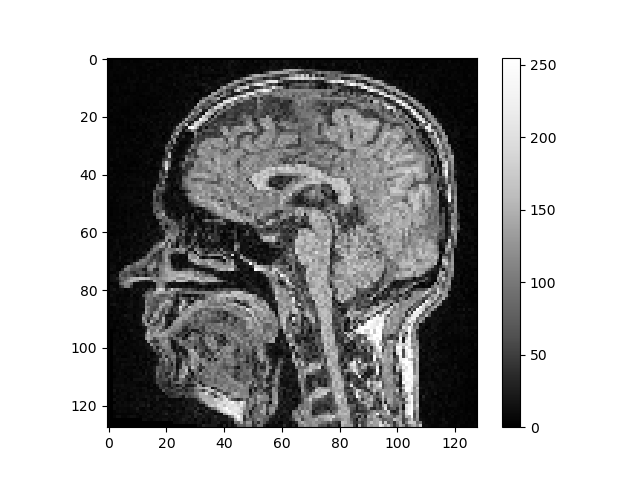
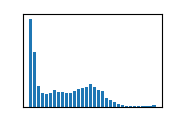

In [7]:
cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
stackview.insight(result[48])

## clEsperanto

clEsperanto affine transform duration: 0.01579570770263672
clEsperanto affine transform duration: 0.005071163177490234
clEsperanto affine transform duration: 0.00540924072265625
clEsperanto affine transform duration: 0.004240274429321289
clEsperanto affine transform duration: 0.00461268424987793
clEsperanto affine transform duration: 0.005407094955444336
clEsperanto affine transform duration: 0.00403904914855957
clEsperanto affine transform duration: 0.005263566970825195
clEsperanto affine transform duration: 0.0051195621490478516
clEsperanto affine transform duration: 0.004664421081542969


StackViewNDArray([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
                  [0.   , 3.   , 4.375, ..., 4.   , 3.875, 4.25 ],
                  [0.   , 3.625, 4.5  , ..., 3.875, 3.625, 3.75 ],
                  ...,
                  [0.   , 0.   , 0.   , ..., 2.625, 3.375, 3.125],
                  [0.   , 0.   , 0.   , ..., 3.25 , 3.875, 3.75 ],
                  [0.   , 0.   , 0.   , ..., 3.25 , 3.5  , 4.625]],
                 dtype=float32)
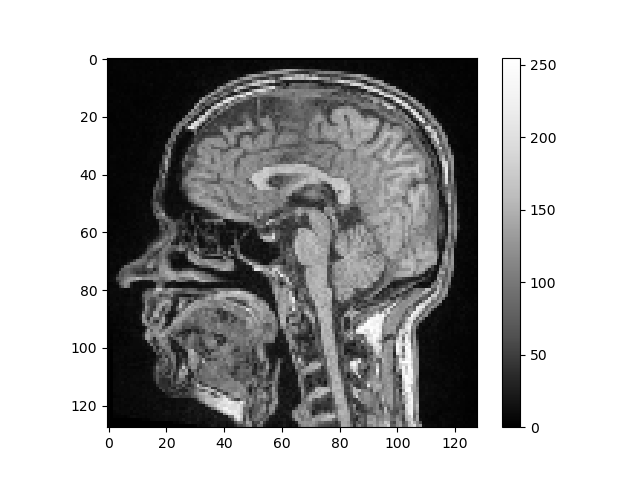
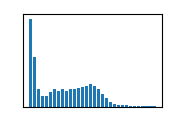

In [8]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
stackview.insight(result[48])

## Scipy

scipy affine transform duration: 1.724757194519043
scipy affine transform duration: 1.7545890808105469
scipy affine transform duration: 1.785327434539795
scipy affine transform duration: 1.8502540588378906
scipy affine transform duration: 1.8263814449310303
scipy affine transform duration: 1.8311867713928223
scipy affine transform duration: 1.7970592975616455
scipy affine transform duration: 1.7730398178100586
scipy affine transform duration: 1.8295350074768066
scipy affine transform duration: 1.84840989112854


StackViewNDArray([[-2.27222983e-19,  6.30122021e-17,  7.06468292e-16,
                   ...,  3.61097932e-16,  3.21908304e-16,
                    4.82649877e-16],
                  [ 3.56472376e-17,  1.00000000e+00,  5.00000000e+00,
                   ...,  3.00000000e+00,  3.00000000e+00,
                    4.00000000e+00],
                  [ 1.47715357e-16,  2.00000000e+00,  5.00000000e+00,
                   ...,  3.00000000e+00,  4.00000000e+00,
                    4.00000000e+00],
                  ...,
                  [-3.62141417e-19,  3.13706045e-19,  3.97919424e-17,
                   ...,  1.00000000e+00,  5.00000000e+00,
                    2.00000000e+00],
                  [-5.76575140e-20,  3.29037468e-19,  5.45755328e-18,
                   ...,  3.00000000e+00,  2.00000000e+00,
                    4.00000000e+00],
                  [-1.21851473e-21, -1.85791985e-20,  7.19935243e-19,
                   ...,  4.00000000e+00,  4.00000000e+00,
                    6.00000000e+00]])
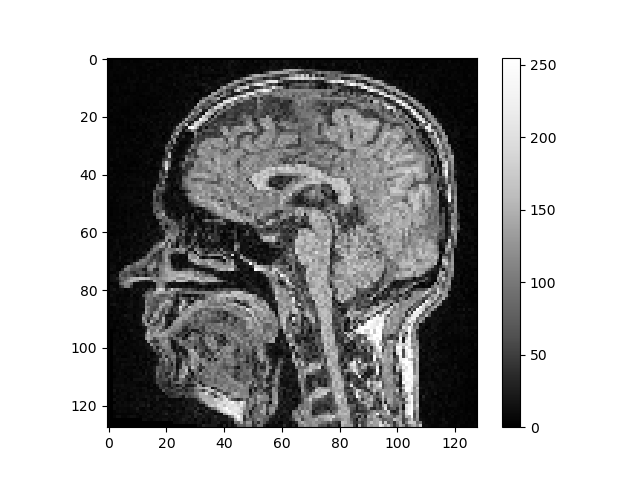
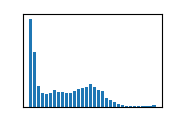

In [9]:
scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

stackview.insight(scaled[48])

## Exercise
Run the benchmark using different input sizes. Make the input image much smaller e.g. by skipping to every 2,3,4th voxel in X,Y and Z (reducing the image size by factor 8, 27, 64). In which case does it make sense to use a GPU and in which not?

## Exercise
Go back 2 weeks to the [exercise where we compared Voronoi-Otsu-Labeling in two libraries](https://github.com/ScaDS/BIDS-lecture-2024/blob/main/04a_image_segmentation/11_voronoi_otsu_labeling.ipynb). Benchmark these two functions. How much faster is the one compared to the other on your laptop? How much faster is it on clara?